In [1]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

import numpy as np

import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.regnorm as regnorm
import mlgrad.avragg as avragg
import mlgrad.clsfy as clsfy

# from mlgrad import erm_fg, erm_irgd, fg, weights, averager_it, erisk, sg, erm_sg

#import sklearn.linear_model as sklm
#import sklearn.datasets as datasets

#plt.style.available

In [2]:
def get_y(lm_line, x):
    return (-lm_line.param[0]-lm_line.param[1]*x)/lm_line.param[2]

In [3]:
def draw_line(lm_line, X, **kw):
    X1, X2 = X[:,0], X[:,1]
    x1_min, x1_max = X1.min(), X1.max()
    x2_min, x2_max = X2.min(), X2.max()
    y1_min = get_y(lm_line, x1_min)
    y1_max = get_y(lm_line, x1_max)

    plt.plot([x1_min, x1_max], [y1_min, y1_max], color='k', linewidth=1.6, **kw)
    
def draw_map(lm_line, X, Y, title):
    plt.figure(figsize=(4.,3.))
    Yp = lm_line.evaluate_all(X)
    plt.title(title)
#     plt.minorticks_on()
    X1, X2 = X[:,0], X[:,1]
    plt.scatter(X1, X2, c=Y, s=16, cmap=plt.cm.gray, edgecolors='k', linewidth=0.5)

    x1_min, x1_max = X1.min(), X1.max()
    x2_min, x2_max = X2.min(), X2.max()
    y1_min = get_y(lm_line, x1_min)
    y1_max = get_y(lm_line, x1_max)

    plt.plot([x1_min, x1_max], [y1_min, y1_max], color='k', linewidth=1.0)
    
#     plt.grid(1)
#     plt.minorticks_on()
#     plt.xticks([],[])
#     plt.yticks([],[])
#     plt.ylim(-15,15)
    plt.tight_layout()
    #plt.show()
    
def draw_map2(X, Y, title, lines):
    plt.figure(figsize=(4.5,4.))
    plt.title(title)
    plt.minorticks_on()
    X1, X2 = X[:,0], X[:,1]
    plt.scatter(X1, X2, c=Y, s=25, cmap=plt.cm.gray, edgecolors='k', linewidth=1)
    x1_min, x1_max = X1.min(), X1.max()
    x2_min, x2_max = X2.min(), X2.max()
    for lm_line, style, label in lines:
        y1_min = get_y(lm_line, x1_min)
        y1_max = get_y(lm_line, x1_max)
        plt.plot([x1_min, x1_max], [y1_min, y1_max], color='k', linestyle=style, label=label)

    plt.ylim(-25,30)
    plt.tight_layout()
    plt.legend(loc='best')
    

In [4]:
def gendataset(N=30, noise=1, q=0.8):
    X0 = 12*np.random.random(N)-6
    Y0 = 0.5 * X0 + 7.*np.random.random(N)+7
    Z0 = np.ones(N)
    X1 = 12*np.random.random(N)-6
    Y1 = 0.5 * X1 + 7.*np.random.random(N)-7
    Z1 = -np.ones(N)
    _X1 = np.hstack((X0,X1))
    _Y1 = np.hstack((Y0,Y1))
    _Z1 = np.hstack((Z0,Z1))
    _X1 = np.c_[_X1, _Y1]
    _Y1 = _Z1
    
    if noise:
        M = int(N*q)
#         M2 = M // 2
        X2 = np.random.random(M)
        X2 = 12*(1-X2**0.2) - 6
        Y2 = 0.5 * X2 
        Y2 -= (6-X2)*np.random.random(M)+7
        Z2 = np.ones(M)
        X3 = np.random.random(M)
        X3 = 12*(X3**0.2) - 6
        Y3 = 0.5 * X3 
        Y3 += (6+X3)*np.random.random(M)+14
        Z3 = -np.ones(M)
        X = np.hstack((X0,X1,X2,X3))
        Y = np.hstack((Y0,Y1,Y2,Y3))
        Z = np.hstack((Z0,Z1,Z2,Z3))
        X = np.c_[X, Y]
        Y = Z
    else:
        X = np.hstack((X0,X1))
        Y = np.hstack((Y0,Y1))
        Z = np.hstack((Z0,Z1))
        X = np.c_[X, Y]
        Y = Z
    return X, Y, _X1, _Y1


In [15]:
N=50
q = 0.7
Q = 100 * q/(1+q)
M = int(N*q)
X, Y, X1, Y1 = gendataset(N, q=q)
print(M, Q, X.shape, Y.shape, X1.shape, Y1.shape)

35 41.1764705882353 (170, 2) (170,) (100, 2) (100,)


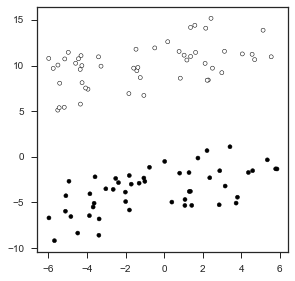

In [16]:
plt.figure(figsize=(4.5,4.5))
plt.scatter(X1[:,0], X1[:,1], s=16, c=Y1, cmap=plt.cm.gray, edgecolors='k', linewidth=0.5)
plt.show()

In [17]:
mod_h = model.LinearModel(2)
mod_h.init_param()

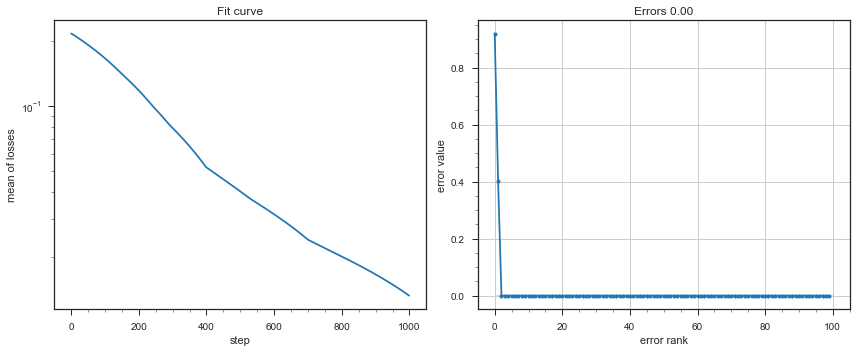

In [18]:
cls_h = clsfy.classification_as_regr(X1, Y1, mod_h)
clsfy.plot_losses_and_errors(cls_h, X1, Y1)

In [19]:
mod_h1 = model.LinearModel(2)
mod_h1.init_param()

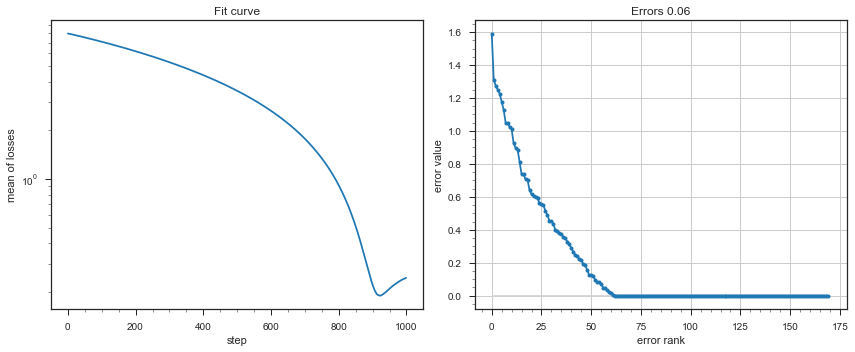

In [20]:
cls_h1 = clsfy.classification_as_regr(X, Y, mod_h1)
clsfy.plot_losses_and_errors(cls_h1, X, Y)

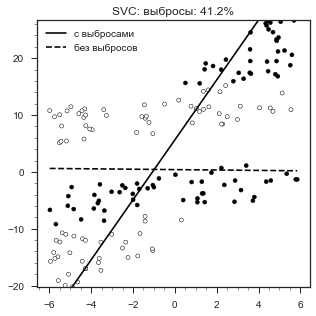

In [21]:
plt.figure(figsize=(4.5,4.5))
X1_1, X1_2 = X[:,0], X[:,1]
plt.title("SVC: выбросы: %.1f%%" % Q)
plt.scatter(X1_1, X1_2, c=Y, s=16, cmap=plt.cm.gray, edgecolors='k', linewidth=0.5)
draw_line(mod_h1, X, label='с выбросами') # label=r'$%.1f%.1fx+%.1fy$ (с выбросами)' % tuple(linmod0.param))
draw_line(mod_h, X1, linestyle='--', label='без выбросов') # , label=r'$%.1f%.1fx+%.1fy$ (без выбросов)' % tuple(linmod1.param)
# plt.xlim(-5,5)
plt.ylim(X1_2.min(),X1_2.max())
plt.minorticks_on()
plt.legend()
plt.tight_layout()
# plt.savefig('fig/linear_svm_1_%.0f.eps' % Q)
plt.show()

In [37]:
mod_mh = model.LinearModel(2)
mod_mh.init_param()

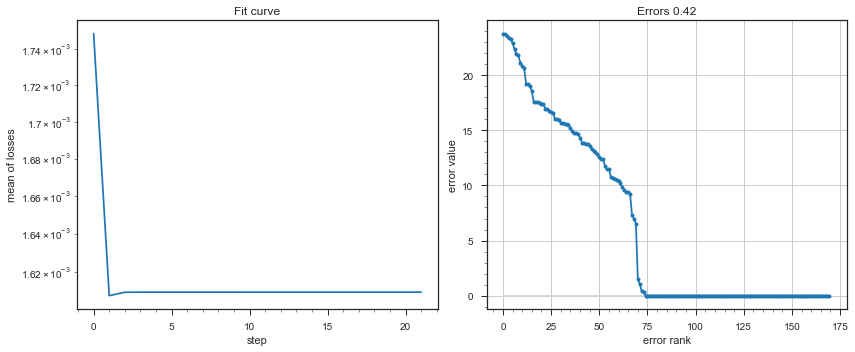

In [38]:
avrfunc = clsfy.averaging_function('SWM', alpha=0.55)
cls_mh = clsfy.classification_as_mregr(X, Y, mod_mh, avrfunc=avrfunc)
clsfy.plot_losses_and_errors(cls_mh, X, Y)

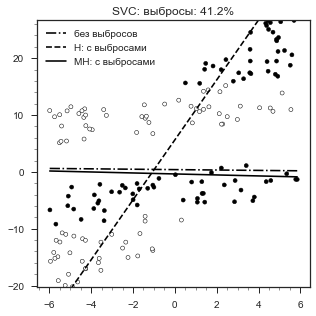

In [39]:
plt.figure(figsize=(4.5,4.5))
X1_1, X1_2 = X[:,0], X[:,1]
plt.title("SVC: выбросы: %.1f%%" % Q)
plt.scatter(X1_1, X1_2, c=Y, s=16, cmap=plt.cm.gray, edgecolors='k', linewidth=0.5)
draw_line(mod_h, X1, linestyle='-.', label='без выбросов')
draw_line(mod_h1, X, linestyle='--', label='H: с выбросами')
draw_line(mod_mh, X1, label='MH: с выбросами')
# plt.xlim(-5,5)
plt.ylim(X1_2.min(),X1_2.max())
plt.minorticks_on()
plt.legend()
plt.tight_layout()
# plt.savefig('fig/linear_svm_2_%.0f.eps' % Q)
plt.show()